In [105]:
import numpy as np
import pandas as pd
# 5- NDA-SE
# 20 - ACTO-A

In [106]:
my_test_result_list = np.load('results.np.npy')
print(my_test_result_list.shape)
filename = "data-prep-ema{}-beta{}.csv".format(10,99)
data = pd.read_csv(filename, parse_dates=["timestamp"])

(56, 258, 4)


In [147]:
data[['last_20','last_5']]

,last_20,last_5
0,0.00,0.000
1,0.00,0.000
2,0.00,0.000
3,0.00,0.000
4,0.00,0.000
5,0.00,0.000
6,228.85,83.000
7,228.25,83.020
8,227.95,83.110
9,228.10,83.070


In [107]:
ori_shape = my_test_result_list.shape



In [108]:
groups = data.set_index('timestamp').groupby(lambda x: x.date())

In [109]:
# start day is the learning period.
ori_shape = my_test_result_list.shape
my_test_result_list = my_test_result_list.reshape(int(ori_shape[0]/2), ori_shape[1]*2, ori_shape[2])
start_day = 30
i = 0
my_df_list = []
for index, df in groups:
    print("handling day: {}".format(i))
    if i >= start_day and i-start_day < len(my_test_result_list):
        print(i)
        my_df = df[['last_20','value_ema_10_beta_99_20','last_5','value_ema_10_beta_99_5']]
        print(len(my_test_result_list[i-start_day,:,0]))
        print(len(my_df))
        my_df['test_y_20'] = my_test_result_list[i-start_day,:,0]
        my_df['test_y_5'] = my_test_result_list[i - start_day,:,1] 
        my_df['valid_y_20'] = my_test_result_list[i - start_day,:,2]
        my_df['valid_y_5'] = my_test_result_list[i - start_day,:,3]
        my_df_list.append(my_df)
    i+=1

handling day: 0
handling day: 1
handling day: 2
handling day: 3
handling day: 4
handling day: 5
handling day: 6
handling day: 7
handling day: 8
handling day: 9
handling day: 10
handling day: 11
handling day: 12
handling day: 13
handling day: 14
handling day: 15
handling day: 16
handling day: 17
handling day: 18
handling day: 19
handling day: 20
handling day: 21
handling day: 22
handling day: 23
handling day: 24
handling day: 25
handling day: 26
handling day: 27
handling day: 28
handling day: 29
handling day: 30
30
516
516
handling day: 31
31
516
516
handling day: 32
32
516
516
handling day: 33
33
516
516
handling day: 34
34
516
516
handling day: 35
35
516
516
handling day: 36
36
516
516
handling day: 37
37
516
516
handling day: 38
38
516
516
handling day: 39
39
516
516
handling day: 40
40
516
516
handling day: 41
41
516
516
handling day: 42
42
516
516
handling day: 43
43
516
516
handling day: 44
44
516
516
handling day: 45
45
516
516
handling day: 46
46
516
516
handling day: 47
47
516


In [117]:
import GPy
import GPyOpt
from functools import partial

In [161]:
mixed_domain = [{'name': 'buy_threshold', 'type': 'continuous', 'domain': (0.0, 0.002)},
                 {'name': 'sell_threshold', 'type': 'continuous', 'domain': (-0.001, 0.0)},
                 {'name': 'min_hold_steps', 'type': 'discrete', 'domain': range(10,100)},
                 {'name': 'stop_loss', 'type': 'continuous', 'domain':(-0.03, -0.002)},
                 {'name': 'stop_gain', 'type': 'continuous', 'domain':(0.001, 0.03)}
         ]
    

    
def opt_wrapper(verbose, X_list):
    
    print(X_list)
    buy_threshold = X_list[0][0]
    sell_threshold = X_list[0][1]
    min_hold_steps = int(X_list[0][2])
    stop_loss = X_list[0][3]
    stop_gain = X_list[0][4]
    #stop_gain = int(X_list[0][4])
    tot_profit = 1
    tot_stock_profit = 1
    last_step = None
    max_trades = 3
    cost = 0.0004
    hold=-1
    tot_trades = 0
    result_list = []
    for day_idx in range(len(my_df_list)):
        #print("starting day {}".format(day_idx))
        trades = 0
        daily_profit = 1
        state = 0
        df = my_df_list[day_idx]
        for step in range(len(df)):
            if state == 0 and trades<max_trades and step > 5 and step < 504-min_hold_steps:
                if df.iloc[step]['test_y_5'] > buy_threshold:
                    price = df.iloc[step]['last_5']
                    hold = 5
                    state = 1
                    last_step = step
                    if verbose:
                        print("buy at step {} price:{}".format(step, price))
                elif df.iloc[step]['test_y_20'] > buy_threshold:
                    price = df.iloc[step]['last_20']
                    hold = 20
                    if verbose:
                        print("buy at step {} price:{}".format(step, price))
                    state = 1
                    last_step = step
            elif state == 1:
                cur_price = df.iloc[step]['last_'+str(hold)]
                tmp_profit = (cur_price - price)/price

                if (df.iloc[step]['test_y_'+str(hold)] < buy_threshold and 
                    step - last_step > min_hold_steps) or step == len(df)-5 or \
                    tmp_profit < stop_loss or \
                    tmp_profit > stop_gain:
                    if verbose and tmp_profit < stop_loss:
                        print("STOP LOSS!!! cur:{} pri:{}, profit:{}, stop_loss:{}".format(cur_price, price, tmp_profit, stop_loss))
                    elif verbose and tmp_profit > stop_gain:
                        print("STOP GAIN!!! cur:{} pri:{}, profit:{}, stop_gain:{}".format(cur_price, price, tmp_profit, stop_gain))
                    last_price = price
                    price = df.iloc[step]['last_'+str(hold)]
                    if verbose:
                        print("sell at step {} price:{}".format(step, price))
                    
                    tot_profit *= (1+tmp_profit-cost)
                    daily_profit *= (1 + tmp_profit - cost)
                    state = 0
                    hold = -1
                    trades += 1
        tot_trades += trades
        last_20 = df.iloc[len(df)-1].last_20
        open_20 = df.iloc[0].last_20
        stock_profit_20 = (last_20 - open_20)/ open_20
        
        last_5 = df.iloc[len(df)-1].last_5
        open_5 = df.iloc[0].last_5
        stock_profit_5 = (last_5 - open_5)/ open_5
        
        stock_profit = (stock_profit_20 + stock_profit_5) / 2
        tot_stock_profit *= (1+stock_profit)
        if verbose:
            result_list.append([day_idx, trades, tot_stock_profit, tot_profit])
            print("finishing day {}, daily_profit:{}, stock_profit:{}".format(day_idx, daily_profit, stock_profit))
    print("{}, profit:{}, stock_profit: {}, tot_trades:{}".format(X_list, tot_profit, tot_stock_profit, tot_trades))
    if verbose:
        return result_list
    return -tot_profit
    

In [159]:
myBopt = GPyOpt.methods.BayesianOptimization(partial(opt_wrapper, False),  # Objective function       
                                     domain=mixed_domain,          # Box-constraints of the problem
                                     initial_design_numdata = 20,   # Number data initial design
                                     acquisition_type='EI',        # Expected Improvement
                                     exact_feval = True)           # True evaluations, no sample noise

myBopt.run_optimization(100,eps=0)

[[ 1.82726449e-03 -9.03955822e-04  5.50000000e+01 -2.28850666e-03
   2.92879803e-02]]


KeyboardInterrupt: 

In [162]:
result_list = opt_wrapper(True, np.array([[ 0.00000000e+00, 0.00000000e+00,  8.50000000e+01, -1.93001242e-02
,   2.78438174e-02]]))

[[ 0.00000000e+00  0.00000000e+00  8.50000000e+01 -1.93001242e-02
   2.78438174e-02]]
buy at step 6 price:81.79
sell at step 92 price:82.7
buy at step 93 price:82.7
sell at step 183 price:82.86
buy at step 186 price:82.85
sell at step 272 price:82.81
finishing day 0, daily_profit:1.0113835810206542, stock_profit:0.013606034219377665
buy at step 6 price:83.45
sell at step 92 price:83.02
buy at step 99 price:82.87
sell at step 186 price:82.96
buy at step 187 price:82.93
sell at step 282 price:82.93
finishing day 1, daily_profit:0.9947313910724119, stock_profit:0.0009285844499134135
buy at step 6 price:82.82
sell at step 96 price:83.11
buy at step 107 price:83.03
sell at step 193 price:82.87
buy at step 194 price:82.9
sell at step 286 price:82.96
finishing day 2, daily_profit:1.0010913499465588, stock_profit:0.0024554739147848313
buy at step 6 price:82.62
sell at step 92 price:83.21
buy at step 94 price:83.25
sell at step 190 price:83.43
buy at step 191 price:247.25
sell at step 277 price

In [163]:
result_df = pd.DataFrame(result_list, columns=['day','trades','stock','profit'])
result_df

,day,trades,stock,profit
0,0,3,1.013606,1.011384
1,1,3,1.014547,1.006055
2,2,3,1.017038,1.007153
3,3,3,1.030604,1.020047
4,4,3,1.033971,1.021625
5,5,3,1.042907,1.031655
6,6,3,1.048835,1.027756
7,7,3,1.035270,1.020382
8,8,3,1.039721,1.016929
9,9,3,1.020114,1.015434


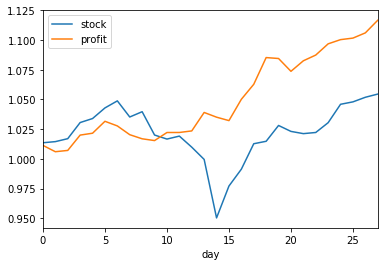

In [164]:
result_df[['day','stock','profit']].plot(x='day')